In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

# Data Generator Digit sets and MNIST sets

In [3]:
# Data Generator for digit and MNIST
# The digits are generated as batch of sets
# The MNIST are generated set by set
class SetsGenerator(object):
    
    def __init__(self, batch_size = 32, set_size=10, cuda=False):
        """
        :param batch_size: int, (default=32) Number of elements for each batch (useful only for digits)
        :param set_size: int (default=10) Number of elements by sets
        :param cuda: boolean default=False), enable GPU usage
        """
        self.batch_size = batch_size
        self.set_size = set_size
        self.cuda = cuda

    def generate_digit(self, inversion_digit_value=None):
        """
        Generator function that creates a batch of sets of digits. The function allows us to change the true
        value of two digit with the parameter inversion_digit_value.
        :param inversion_digit_value: Dictionary, the value of the digit for the key and for the value are switched
        :return:
        """
        while 1:
            X = np.random.randint(10, size=(self.set_size*self.batch_size))
            # Arrangement of the data into the set's format (batch_size, set_size, digit_size)
            X = np.reshape(X, (self.batch_size, self.set_size, 1))
            # inversion of the key and value in inversion_digit_value
            for key, value in inversion_digit_value.iteritems():
                X_tmp = np.apply_along_axis(lambda x: np.where(x == [key], [-1], x), 1, X)
                X_tmp = np.apply_along_axis(lambda x: np.where(x == [value], [key], x), 1, X_tmp)
                X_tmp = np.apply_along_axis(lambda x: np.where(x == [-1], [value], x), 1, X_tmp)
            # Compute the label
            y = np.sum(X_tmp,axis=1)
            y = np.reshape(y,(self.batch_size,1,1))
            if(self.cuda):
                yield Variable(torch.Tensor(X)).cuda(), Variable(torch.Tensor(y), requires_grad=False).cuda()
            else:
                yield Variable(torch.Tensor(X)), Variable(torch.Tensor(y), requires_grad=False)
                
    def generate_mnist(self):
        """
        Generator function that creates a sets of MNIST.
        :return:
        """
        # We first create a mnist loader that load a set of mnist
        kwargs = {'num_workers': 1, 'pin_memory': True}
        mnist_loader = torch.utils.data.DataLoader(
            datasets.MNIST('./data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=self.set_size, shuffle=True, **kwargs)
        mnist_loader_iter = iter(mnist_loader)
        cpt = 0
        while 1:
            # If the iterator is finished we reload it
            if(cpt != 0 and len(mnist_loader) % cpt == 0):
                mnist_loader_iter = iter(mnist_loader)
                cpt = 0
            x, y_ = mnist_loader_iter.next()
            y_ = torch.Tensor(np.reshape(y_.sum(), (1, 1)))
            cpt += 1
            if(self.cuda):
                yield Variable(x).cuda(), Variable(y_).cuda().float()
            else:
                yield Variable(x), Variable(y_).float()


# DeepSets on digits

In [4]:
class Digit_DeepSets(nn.Module):
    def __init__(self):
        super(Digit_DeepSets, self).__init__()
        self.affine1 = nn.Linear(1, 32)
        self.affine2 = nn.Linear(32, 16)
        self.affine3 = nn.Linear(16, 1)
        
    def forward(self, x):
        # phi network
        x = F.relu(self.affine1(x))
        
        # Summing phi representation
        x = x.sum(1)
        
        # rho network
        x = F.relu(self.affine2(x))
        x = F.relu(self.affine3(x))
        return x

In [10]:
batch_size = 32
cuda = True
n_iter_train = 30001
learning_rate = 0.2
n_compute_loss = n_iter_train/10
inversion_digit_value = {3:5,9:1,0:4}

gen = SetsGenerator(batch_size = batch_size, cuda=cuda)

if(cuda):
    deepsets = Digit_DeepSets().cuda()
else:
    deepsets = Digit_DeepSets()

optimizer = optim.Adam(deepsets.parameters())

l = 0
for i, (x, y_) in enumerate(gen.generate_digit(inversion_digit_value)):
    optimizer.zero_grad()
    y = deepsets(x)
    loss = F.mse_loss(y, y_)
    loss.backward()
    l += loss.data[0]
    optimizer.step()
    if i % n_compute_loss == 0 and i != 0:
        print 'Train Epoch: %s, loss: %s'%(i, l*1./n_compute_loss)
        l = 0
    if i > n_iter_train:
        break

Train Epoch: 3000, loss: 16.4874633823
Train Epoch: 6000, loss: 6.93370559144
Train Epoch: 9000, loss: 5.03602573391
Train Epoch: 12000, loss: 3.08291036415
Train Epoch: 15000, loss: 2.23616418028
Train Epoch: 18000, loss: 1.95305840341
Train Epoch: 21000, loss: 1.83819900312
Train Epoch: 24000, loss: 1.78652972317
Train Epoch: 27000, loss: 1.64499488419
Train Epoch: 30000, loss: 1.1242852026


In [22]:
# TEST
x, y_ = gen.generate_digit(inversion_digit_value).next()

print "Don't forget that we switched numbers\n"
print "The set of digits is : %s"%np.array(x[0].data).reshape((1, x[0].data.shape[0]))[0]
print "Real sum value of x : %s\n"%np.array(y_[0].data)[0][0]

# Compute the sum with the deepSets neural network
y = deepsets(x[0].view(1, x[0].shape[0], x[0].shape[1]))
print "Value computed by the network : %s\n"%np.array(y.data[0])[0]

Don't forget that we switched numbers

The set of digits is : [3. 8. 6. 1. 2. 2. 7. 5. 3. 2.]
Real sum value of x : 41.0

Value computed by the network : 41.238808



# DeepSets PyTorch MNIST

In [ ]:
class MNIST_DeepSets(nn.Module):
    def __init__(self):
        super(MNIST_DeepSets, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 1024)
        self.fc1_drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(1024, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        # phi network
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 7 * 7 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        
        # Summing phi representation
        x = x.sum(0)
        
        # rho network
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        return x

In [44]:
set_size = 10
cuda = True
n_iter_train = 100001
learning_rate = 0.2
n_compute_loss = n_iter_train/10

gen = SetsGenerator(cuda=cuda, set_size=set_size)
if(cuda):
    deepsets = MNIST_DeepSets().cuda()
else:
    deepsets = MNIST_DeepSets()

optimizer = optim.Adam(deepsets.parameters())

l = 0
for i, (x, y_) in enumerate(gen.generate_mnist()):
    optimizer.zero_grad()
    y = deepsets(x)
    loss = F.mse_loss(y, y_)
    loss.backward()
    l += loss.data[0]
    optimizer.step()
    if i % n_compute_loss == 0 and i != 0:
        print 'Train Epoch: %s, loss: %s'%(i, l*1./n_compute_loss)
        l = 0
    if i > n_iter_train:
        break


Train Epoch: 1500, loss: 12.1580268755
Train Epoch: 3000, loss: 11.0289138915
Train Epoch: 4500, loss: 11.036243445
Train Epoch: 6000, loss: 9.8655818582
Train Epoch: 7500, loss: 11.6816763163
Train Epoch: 9000, loss: 10.723198155
Train Epoch: 10500, loss: 10.820460505
Train Epoch: 12000, loss: 10.3536683721
Train Epoch: 13500, loss: 10.3291602301
Train Epoch: 15000, loss: 11.3002893637


The set of mnist is :


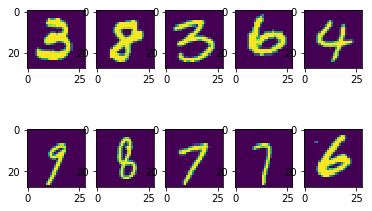

Real sum value of x : 61.0

Value computed by the network : 60.97220230102539



In [58]:
# TEST
x, y_ = gen.generate_mnist().next()

print "The set of mnist is :"
for i, im in enumerate(x):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.reshape(np.array(im.data), (28,28)))
plt.show()
print "Real sum value of x : %s\n"%np.array(y_[0].data)[0]

# Compute the sum with the deepSets neural network
y = deepsets(x)
print "Value computed by the network : %s\n"%np.array(y.data[0])